In [266]:
import yfinance as yf
import ta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
# import warnings
# warnings.filterwarnings("ignore")

import datetime
import holidays 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [267]:
def display_metrics(df):
    # Calculating error metrics
    mse = mean_squared_error(df['Close'], df['preds'])
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    rmse = mean_squared_error(df['Close'], df['preds'], squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    mape = (abs(df['Close'] - df['preds']) / df['Close']).mean() * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In [268]:
def plot_train_test(train, test):
    plt.figure(figsize=(12, 6))

    # Plot the actual close prices from train data
    sns.lineplot(x=train.index, y=train['Close'], label="Train Data (Actual Close)", color="blue")

    # Plot the actual close prices from test data
    sns.lineplot(x=test.index, y=test['Close'], label="Test Data (Actual Close)", color="green")

    # Plot the naive random walk predictions for test data
    sns.lineplot(x=test.index, y=test['preds'], label="Test Data (Predicted)", color="red", linestyle="dashed")

    # Customize labels and title
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("Train vs. Test Data: Actual vs Predictions (ON TEST DATA)")
    plt.legend()

    # Show the plot
    plt.show()
    

In [269]:
def plot_oos(df_actual, df_preds):
    ## Plotting Predictions
    # Plot the actual and predicted stock prices
    plt.figure(figsize=(12, 6))

    # Plot the actual close prices
    sns.lineplot(x=df_actual.index, y=df_actual['Close'], label="Actual Close Price", color="blue")

    # Plot the naive random walk predictions
    sns.lineplot(x=df_preds['dt'], y=df_preds['preds'], label="Prediction", color="red", linestyle="dashed")

    # Customize labels and title
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("Actual vs. Predicted Stock Prices (OUT OF SAMPLE)")
    plt.legend()

    # Show the plot
    plt.show()

In [270]:
data = yf.Ticker("CAVA")

df = pd.DataFrame(data.history(period='max'))

##Filter to 3 years of history (if available)... else use all history
last_date = df.index[-1]
three_years_ago = last_date - pd.DateOffset(years=3)

if df.index[0] < three_years_ago:
    df_filtered = df[df.index >= three_years_ago]  # Use last 3 years
    print("Filtered to last 3 years: ", df_filtered.index.min())
else:
    df_filtered = df  # Use all data if less than 3 years
    print("Less than 3 years of data: ", df_filtered.index.min())
print(df_filtered.tail(3))
print(df_filtered[['Close']].describe())


Less than 3 years of data:  2023-06-16 00:00:00-04:00
                                Open       High        Low      Close  \
Date                                                                    
2025-03-20 00:00:00-04:00  82.620003  86.669998  81.699997  84.660004   
2025-03-21 00:00:00-04:00  83.330002  84.190002  81.129997  83.849998   
2025-03-24 00:00:00-04:00  87.339996  90.489998  86.400002  90.330002   

                            Volume  Dividends  Stock Splits  
Date                                                         
2025-03-20 00:00:00-04:00  5887300        0.0           0.0  
2025-03-21 00:00:00-04:00  3610300        0.0           0.0  
2025-03-24 00:00:00-04:00  3705400        0.0           0.0  
            Close
count  443.000000
mean    78.092325
std     36.840099
min     29.980000
25%     43.895000
50%     72.169998
75%    115.100002
max    150.880005


In [271]:
df_filtered['Close']

Date
2023-06-16 00:00:00-04:00    38.150002
2023-06-20 00:00:00-04:00    38.430000
2023-06-21 00:00:00-04:00    38.340000
2023-06-22 00:00:00-04:00    39.160000
2023-06-23 00:00:00-04:00    40.150002
                               ...    
2025-03-18 00:00:00-04:00    76.779999
2025-03-19 00:00:00-04:00    81.000000
2025-03-20 00:00:00-04:00    84.660004
2025-03-21 00:00:00-04:00    83.849998
2025-03-24 00:00:00-04:00    90.330002
Name: Close, Length: 443, dtype: float64

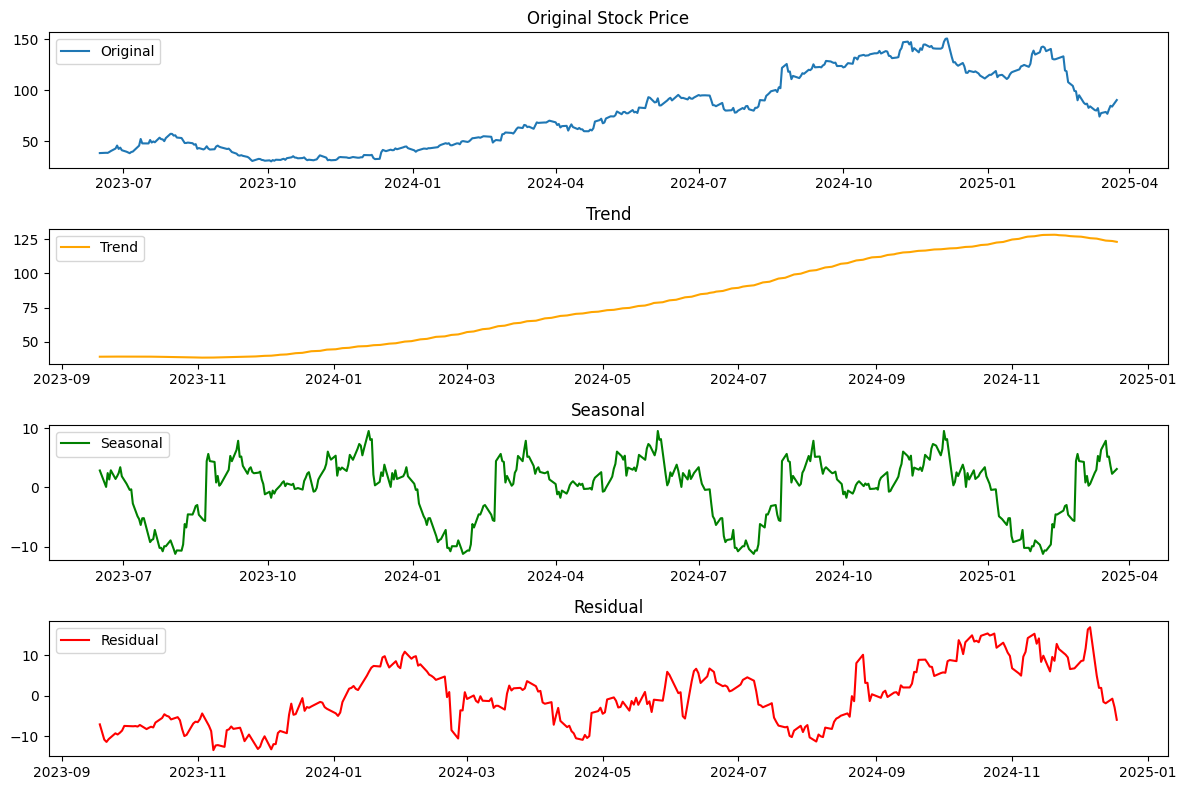

Date
2023-06-16 00:00:00-04:00    2.855701
2023-06-20 00:00:00-04:00    0.088134
2023-06-21 00:00:00-04:00    2.425330
2023-06-22 00:00:00-04:00    1.338544
2023-06-23 00:00:00-04:00    2.887769
Name: seasonal, dtype: float64


In [272]:
period = round(252 / 2) # Use period=252 for daily data (1 year of trading days)
result = seasonal_decompose(df_filtered['Close'], model='additive', period=period)  

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_filtered['Close'], label='Original')
plt.title('Original Stock Price')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.title('Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='red')
plt.title('Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Extract the seasonal component
seasonality = result.seasonal

# Print out the first few values of the seasonal component
print(seasonality.head())

# Now you can use seasonality for further analysis or forecasting

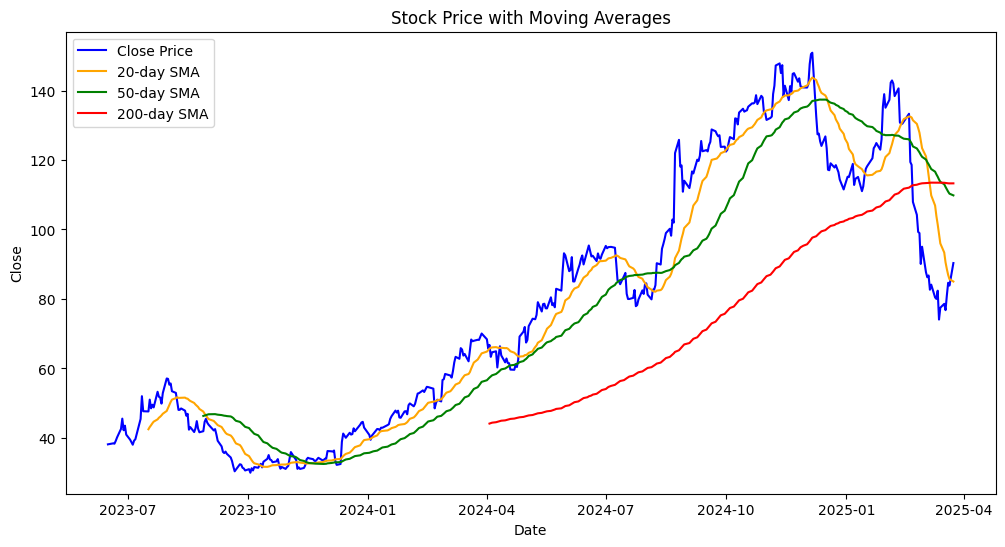

In [273]:
import seaborn as sns
import matplotlib.pyplot as plt

# Simple Moving Average (SMA)
df_filtered['SMA_20'] = df_filtered['Close'].rolling(window=20).mean()
df_filtered['SMA_50'] = df_filtered['Close'].rolling(window=50).mean()
df_filtered['SMA_200'] = df_filtered['Close'].rolling(window=200).mean()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_filtered.index, y=df_filtered['Close'], label="Close Price", color="blue")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_20'], label="20-day SMA", color="orange")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_50'], label="50-day SMA", color="green")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_200'], label="200-day SMA", color="red")

plt.title("Stock Price with Moving Averages")
plt.show()

## 50-day moving average (SMA) crosses above the 200-day moving average (SMA), Bullish
# 50-day moving average (SMA) crosses below the 200-day moving average (SMA), Bearish


# Begin Modeling

In [ ]:
## Test Data
test_length = 30
test_data = df_filtered[["Close"]].tail(test_length).copy()
first_test_date = test_data.index[0] # To make train

# Train Data
train_data = df_filtered[df_filtered.index < first_test_date][["Close"]].copy()


In [275]:
## Constants for Modeling

df_to_model = df_filtered[['Close']].copy()
predictions_df = pd.DataFrame()
last_price = df_to_model['Close'].iloc[-1]
days_of_trading_to_predict = 100


## Creating future dates to predict
us_holidays = holidays.UnitedStates(years = [2025,2026])
current_datetime = datetime.datetime.today()
formatted_date = current_datetime.strftime("%d/%m/%Y")
future_dates = pd.date_range(start=formatted_date, periods=days_of_trading_to_predict, freq='B')
# Remove U.S. holidays from the generated business days
future_dates = [date for date in future_dates if date not in us_holidays]

# Keep only the first `days_of_trading_to_predict` valid trading days
future_dates = future_dates[:days_of_trading_to_predict]

predictions_df = pd.DataFrame({'dt': future_dates})

predictions_df

,dt
0,2025-03-24
1,2025-03-25
2,2025-03-26
3,2025-03-27
4,2025-03-28
...,...
92,2025-08-04
93,2025-08-05
94,2025-08-06
95,2025-08-07


## Naive Random Walk (Baseline)

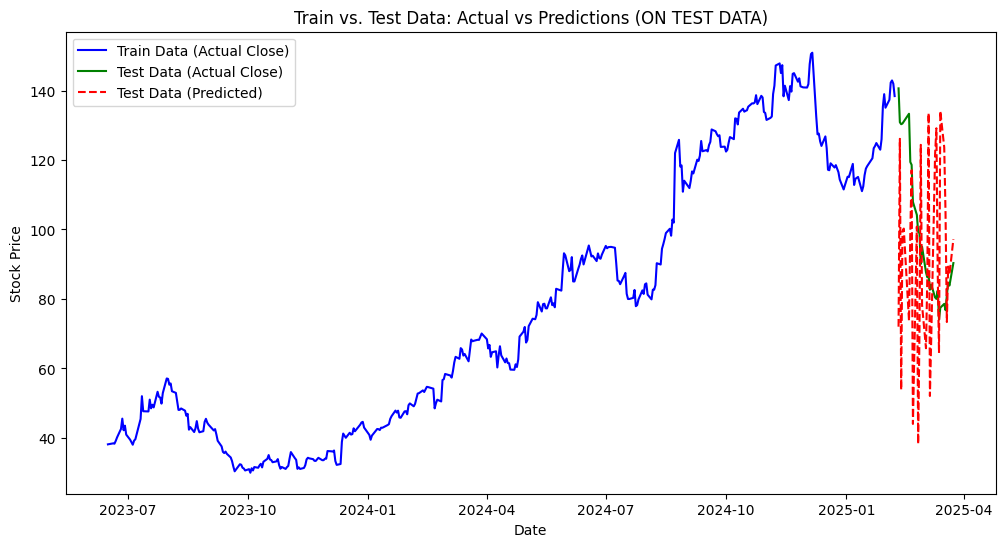

Mean Squared Error (MSE): 1359.6637
Root Mean Squared Error (RMSE): 36.8736
Mean Absolute Percentage Error (MAPE): 29.67%


In [276]:
## TEST

test_df_naive = test_data.copy()

mu = 0  # Mean return (0 for pure random walk)
std_dev = test_df_naive['Close'].std()
sigma = std_dev  # Standard deviation of returns

closes = np.random.normal(mu, sigma, len(test_data))
closes = closes + last_price

test_df_naive['preds'] = closes

plot_train_test(train_data, test_df_naive)
display_metrics(test_df_naive)

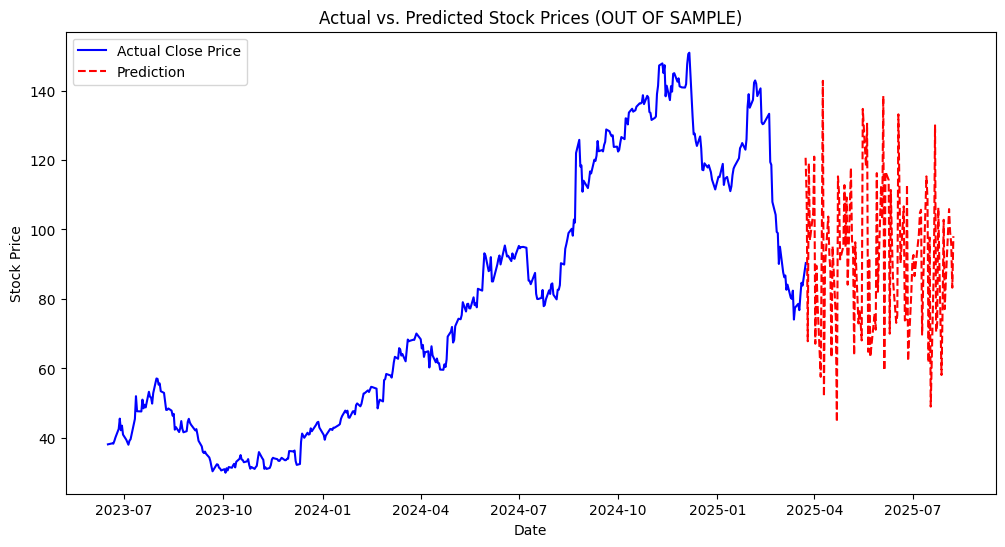

In [277]:
## OUT OF SAMPLE
predictions_df_naive = predictions_df.copy()

# Generate random walk
closes = np.random.normal(mu, sigma, len(predictions_df_naive))
std_dev = df_to_model['Close'].std()
closes = closes + last_price

predictions_df_naive['preds'] = closes


## Plotting Predictions
plot_oos(df_to_model, predictions_df_naive)

## Simple Moving Average

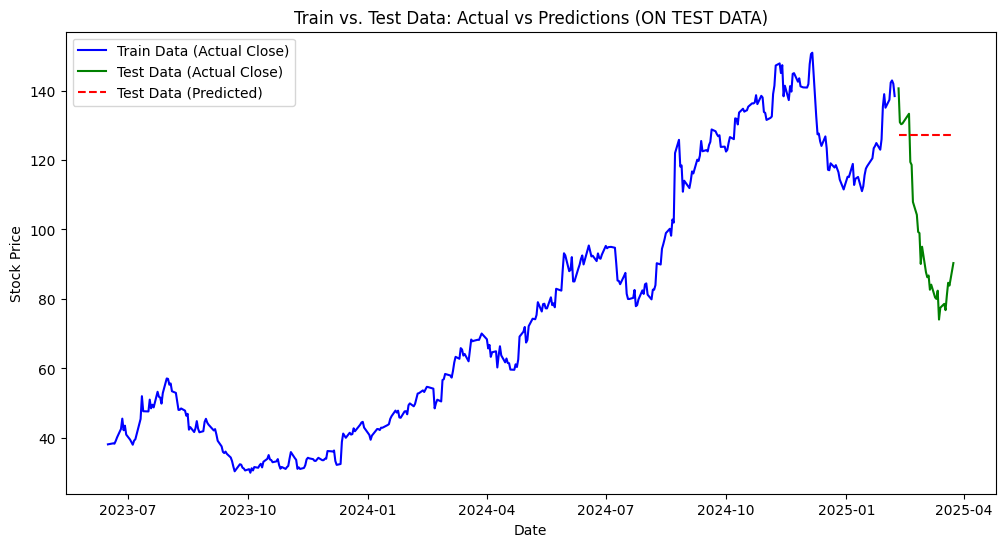

Mean Squared Error (MSE): 1259.7874
Root Mean Squared Error (RMSE): 35.4935
Mean Absolute Percentage Error (MAPE): 36.30%


In [278]:
## TEST
test_df_ma = test_data.copy()
moving_avg_window = 20  # 20-day moving average
train_data['SMA_20'] = train_data['Close'].rolling(window=moving_avg_window).mean()

# Use the last value of the SMA as a baseline for future predictions
# We will predict that future stock prices (for test data) will follow the last known SMA value
last_sma_value = train_data['SMA_20'].iloc[-1]

# For the test data, predict using the last SMA value

test_df_ma['preds'] = last_sma_value

# Plotting actual and predicted values
plot_train_test(train_data, test_df_ma)
display_metrics(test_df_ma)


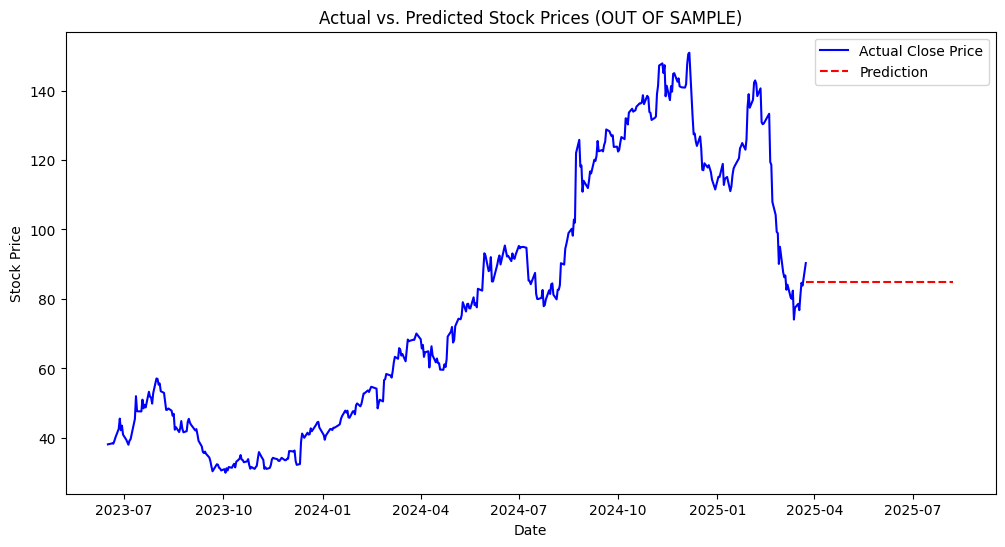

In [279]:
## OUT OF SAMPLE
predictions_df_sma = predictions_df.copy()

moving_avg_window = 20  # 20-day moving average
df_to_model['SMA_20'] = df_to_model['Close'].rolling(window=moving_avg_window).mean()
last_sma_value = df_to_model['SMA_20'].iloc[-1]

predictions_df_sma['preds'] = last_sma_value

# Plotting Predictions
plot_oos(df_to_model, predictions_df_sma)


## ARIMA

In [280]:
# ## TEST

# # Copy test data
# test_df_arima = test_data.copy()

# # Fit ARIMA model on train_data (adjust p, d, q as needed)
# model = ARIMA(train_data['Close'], order=(30, 1, 10))
# model_fit = model.fit()

# # Generate predictions for the test period
# # test_df_arima['preds'] = model_fit.forecast(steps=len(test_df_arima))
# preds = model_fit.forecast(steps=len(test_df_arima))
# test_df_arima['preds'] = preds.values

# # Plot results
# plot_train_test(train_data, test_df_arima)

# # Display performance metrics
# display_metrics(test_df_arima)

In [281]:
# ## OUT OF SAMPLE
# predictions_df_arima = predictions_df.copy()

# model = ARIMA(df_to_model['Close'], order=(30, 1, 10))
# model_fit = model.fit()
# preds = model_fit.forecast(steps=len(predictions_df))

# predictions_df_arima['preds'] = preds.values


# ## Plotting Predictions
# plot_oos(df_to_model, predictions_df_sma)

## Linear Regression

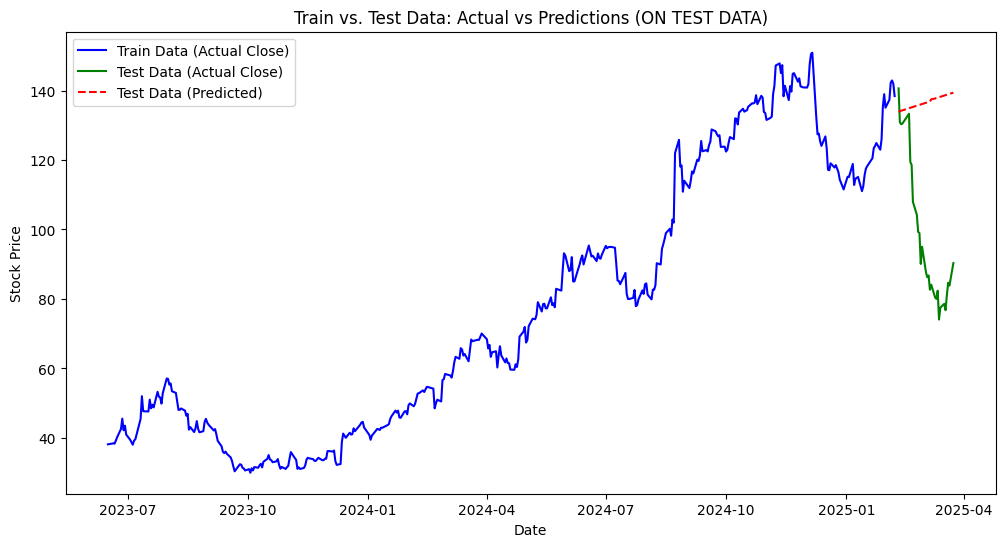

Mean Squared Error (MSE): 1956.0438
Root Mean Squared Error (RMSE): 44.2272
Mean Absolute Percentage Error (MAPE): 45.21%


In [316]:
## TEST
from sklearn.linear_model import LinearRegression

## ADD LAG FEATURE... NEED TO MAKE LAG FEATURE ETC... from this dataset: df_to_model... then split into train & test
## Test Data
# test_length = 30
# test_data = df_filtered[["Close"]].tail(test_length).copy()
# first_test_date = test_data.index[0] # To make train

# # Train Data
# train_data = df_filtered[df_filtered.index < first_test_date][["Close"]].copy()
# lag_value = days_of_trading_to_predict + 1
# train_df_lin_reg['lag'] = train_df_lin_reg['Close'].shift(lag_value)

## Make new cell and do this 

# Copy test data
train_df_lin_reg = train_data.copy()
test_df_lin_reg = test_data.copy()


reference_date_train = train_df_lin_reg.index.min()
time_diff = reference_date_train - train_df_lin_reg.index
train_df_lin_reg['days_past'] = time_diff.days
train_df_lin_reg['months_past'] = time_diff.days // 30  # Approximation of months
train_df_lin_reg['years_past'] = time_diff.days // 365  # Approximation of years
train_df_lin_reg[['days_past', 'months_past', 'years_past']] = train_df_lin_reg[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())


time_diff = reference_date_train - test_df_lin_reg.index
test_df_lin_reg['days_past'] = time_diff.days
test_df_lin_reg['months_past'] = time_diff.days // 30  # Approximation of months
test_df_lin_reg['years_past'] = time_diff.days // 365  # Approximation of years
test_df_lin_reg[['days_past', 'months_past', 'years_past']] = test_df_lin_reg[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

X_train = train_df_lin_reg[['days_past', 'months_past', 'years_past']]
y_train = train_df_lin_reg['Close']  

X_test = test_df_lin_reg[['days_past', 'months_past', 'years_past']]
y_test = test_df_lin_reg['Close']  

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
test_df_lin_reg['preds'] = y_pred

# Plot results
plot_train_test(train_data, test_df_lin_reg)

# Display performance metrics
display_metrics(test_df_lin_reg)

In [ ]:
train_df_lin_reg

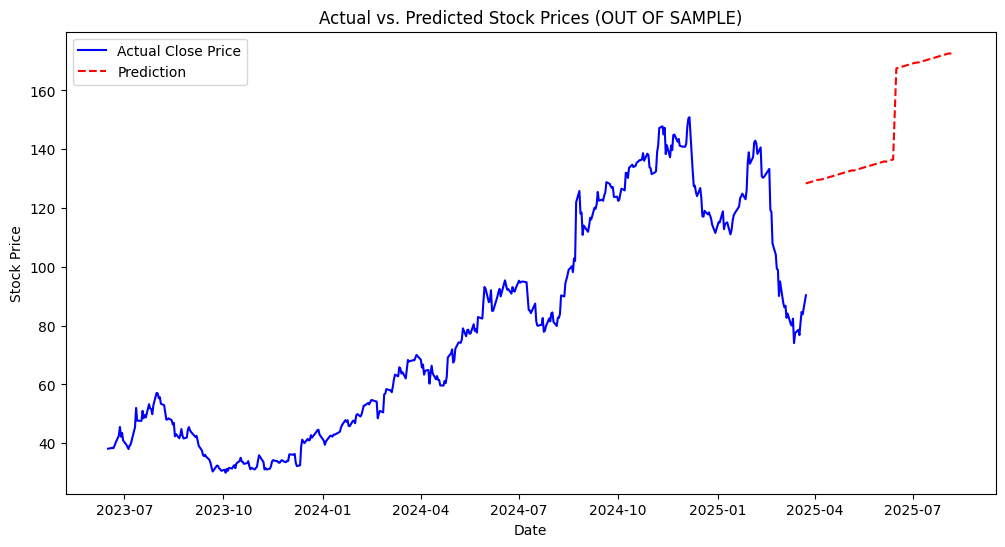

In [314]:
## OUT OF SAMPLE
predictions_df_lin_reg = predictions_df.copy()

reference_date = df_to_model.index.min()
time_diff = reference_date - df_to_model.index
df_to_model['days_past'] = time_diff.days
df_to_model['months_past'] = time_diff.days // 30  # Approximation of months
df_to_model['years_past'] = time_diff.days // 365  # Approximation of years
df_to_model[['days_past', 'months_past', 'years_past']] = df_to_model[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

## Feature creation for the predictions
predictions_df_lin_reg['dt'] = pd.to_datetime(predictions_df_lin_reg['dt'])
predictions_df_lin_reg['dt'] = predictions_df_lin_reg['dt'].dt.date
reference_date = pd.to_datetime(reference_date).date()
time_diff = reference_date - predictions_df_lin_reg['dt']

predictions_df_lin_reg['days_past'] = time_diff.dt.days
predictions_df_lin_reg['months_past'] = time_diff.dt.days // 30  # Approximation of months
predictions_df_lin_reg['years_past'] = time_diff.dt.days // 365  # Approximation of years
predictions_df_lin_reg[['days_past', 'months_past', 'years_past']] = predictions_df_lin_reg[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

X_train = df_to_model[['days_past', 'months_past', 'years_past']]
y_train = df_to_model['Close']  

X_forecast = predictions_df_lin_reg[['days_past', 'months_past', 'years_past']]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_forecast)
predictions_df_lin_reg['preds'] = y_pred


## Plotting Predictions
plot_oos(df_to_model, predictions_df_lin_reg)

In [313]:
predictions_df_lin_reg

,dt,days_past,months_past,years_past
0,2025-03-24,647,22,2
1,2025-03-25,648,22,2
2,2025-03-26,649,22,2
3,2025-03-27,650,22,2
4,2025-03-28,651,22,2
...,...,...,...,...
92,2025-08-04,780,26,3
93,2025-08-05,781,27,3
94,2025-08-06,782,27,3
95,2025-08-07,783,27,3


In [ ]:
predictions_df_lin_reg

,dt
0,2025-03-24
1,2025-03-25
2,2025-03-26
3,2025-03-27
4,2025-03-28
...,...
92,2025-08-04
93,2025-08-05
94,2025-08-06
95,2025-08-07
